### Загрузим основные пакеты

In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [2]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(12,8)})

### Попробуем немного другую модель: $y= 3\sin(-3 \pi x)+5x + \varepsilon$

In [3]:
size = 500

def create_sorted(size):
    # x = np.random.uniform(size=size)
    x = np.linspace(0,1, size)
    x = x - x.mean()
    # Не забудем отсортировать !!!
    x = np.sort(x)
    eps=np.random.uniform(size=size)*2
    eps=eps-eps.mean()
    y = 3*np.sin(-3*np.pi*x)+5*x + 2*eps
    return x, y

x, y = create_sorted(size)

### Вспомним Lowess

<AxesSubplot:>

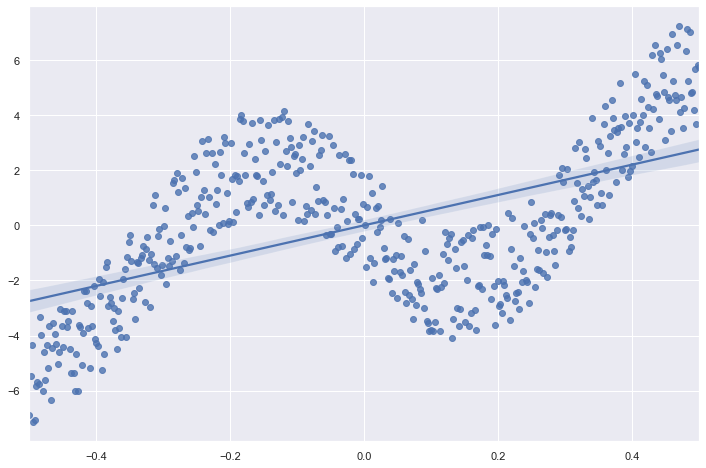

In [4]:
sb.regplot(x=x, y=y)

<AxesSubplot:>

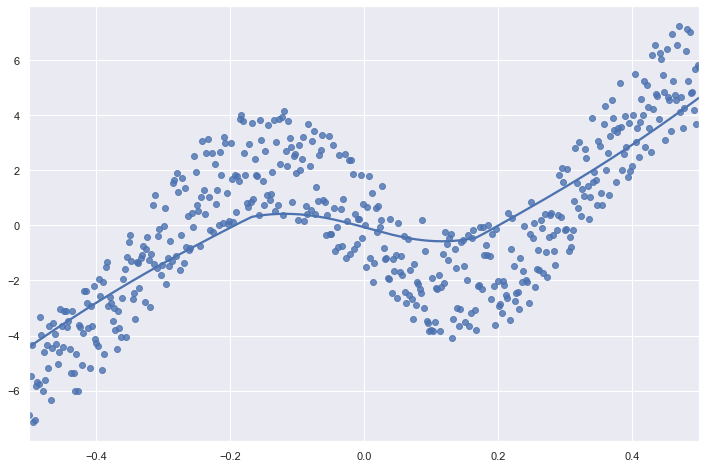

In [5]:
sb.regplot(x=x, y=y, lowess = True)

### Иногда хочется, чтобы фит был нелинейный, но при этом монотонный
### Такая регрессия называется изотонической

In [6]:
import statsmodels.tools.tools as tools
from  sklearn.isotonic import IsotonicRegression as iso_python
iso_python?

### Пример из хелпа мне не удалось воссоздать поэтому будет вот этот пример
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_isotonic_regression.html#sphx-glr-auto-examples-miscellaneous-plot-isotonic-regression-py

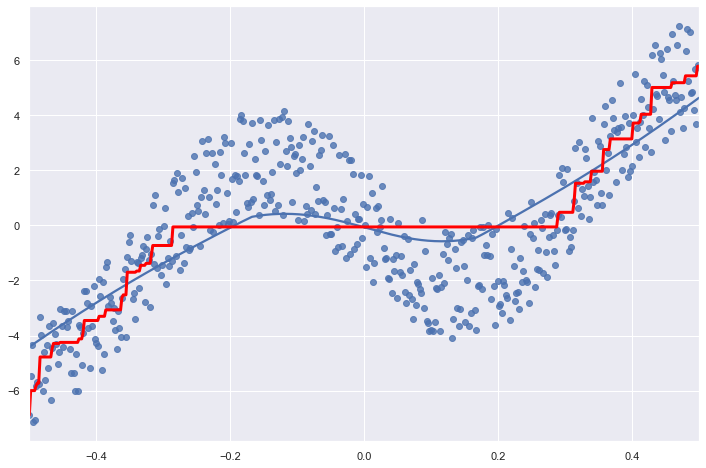

In [7]:
ir = iso_python(out_of_bounds="clip")
y_ = ir.fit_transform(x, y)
sb.regplot(x=x, y=y, lowess = True)
plt.plot(np.sort(x), np.sort(y_), color = 'red', linewidth = 3)

### Что такое вообще isotone regression?
$$ \min_{f} \sum (f(x_i) - x_i)^2 \quad \text{s.t.} \quad f(x_i) < f(x_{i+1})$$
Вообще говоря, это довольно уродливый Лагранжиан и прооптимизировать его просто так не удастся. Но кто то догадался, что монотонная регрессия это почти что то же самое что 
- отсортировать ряд по $x$
- проинтегрировать ряд: $v_i = \sum_{k<i} y_k$
- взять у него выпуклую оболочку снизу $v_i \to \tilde v_i$, это называется gcm, у которого есть линейный по времени алгоритм
- продифференциировать ряд $\tilde y_i = \tilde v_i - \tilde v_{i-1}$ 

К сожалению, в питоне gcm нет, так что мне пришлось вызвать R

### Чтобы установить R, надо через conda устаноовить пакет r-essentials. С первого раза может не получиться, особенно если у вас уже был установлен R.

In [13]:
!which python
!which R

/usr/bin/python
/usr/local/bin/R


In [14]:
%%capture
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [15]:
%%capture
%R library(fdrtool)

In [16]:
def gcm_R(x, y):
    %Rpush x
    %Rpush y
    %R gg = gcmlcm(x, y)
    x_ = %R gg$x.knots
    y_ = %R gg$y.knots
    x__ = np.linspace(-.5,.5, size)
    f = sp.interpolate.interp1d(x_, y_, fill_value=0, bounds_error=False)
    return x__, f(x__)

def iso_R(x,y):
    %Rpush x
    %Rpush y
    gg = %R isoreg(x, y)
    return gg[2]

UsageError: Line magic function `%Rpush` not found.


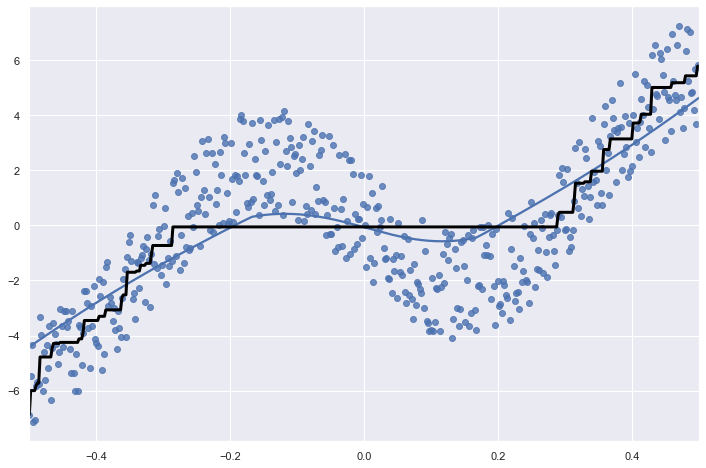

In [17]:
sb.regplot(x=x, y=y, lowess = True)

ir = iso_python(out_of_bounds="clip")
y_ = ir.fit_transform(x, y)
plt.plot(x, y_, color = 'black', linewidth = 3)

cumy = np.cumsum(y)
x__, v = gcm_R(x,cumy)
y__ = np.diff(v, prepend=0)
plt.plot(x__, y__+.2, color = 'red', linewidth = 3)

y___ = np.array(iso_R(x,y))
plt.plot(x, y___+.4, color = 'orange', linewidth = 3)

### Три ответа сошлись

### А еще можно просто отсортировать lowess, но об этом только в самых крутых статьях пишут, это называется rearrangement. То есть просто берем fitted values и применяем к нему np.sort() все